In [1]:
import pathlib as pl
from configparser import ConfigParser
from math import factorial
import itertools as itt

import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import numpy.ma as ma
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from tqdm import tqdm

from src.visualization.interactive import plot_raw_pair
from src.visualization.palette import TENCOLOR, ColorList
from src.data.rasters import load_site_formated_raster
from src.root_path import config_path
from src.data.load import load
from src.utils.subsets import good_sites as sites


config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-08-02 183421.log


In [2]:
site = 'TNC014a'
site = 'ARM021b'

raster, goodcells = load_site_formated_raster(site, part='all')
pupil, _ = load_site_formated_raster(site, part='all', pupil=True, zscore=False)
pupil = pupil.mean(axis=-1, keepdims=True)

In [3]:
# now masks the data by the pupil criteria

threshold = np.median(pupil)
mask = np.broadcast_to(pupil<threshold, raster.shape)
big = ma.masked_where(mask, raster)
big_pupil = ma.masked_where(pupil<threshold, pupil)

mask = np.broadcast_to(pupil>=threshold, raster.shape)
small = ma.masked_where(mask, raster)
small_pupil = ma.masked_where(pupil>=threshold, pupil)

In [4]:
# plot one example
probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'


fig = plot_raw_pair(cellid, ctx_pair,probe, raster_fs=20, colors=TENCOLOR)
fig.show()

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM021b_8f6859fa74514e5cbf8c7195cd1cb785190c1112.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM021/ARM021b06_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM021/ARM021b06_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM021/ARM021b07_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM021/ARM021b07_p_CPN.evp


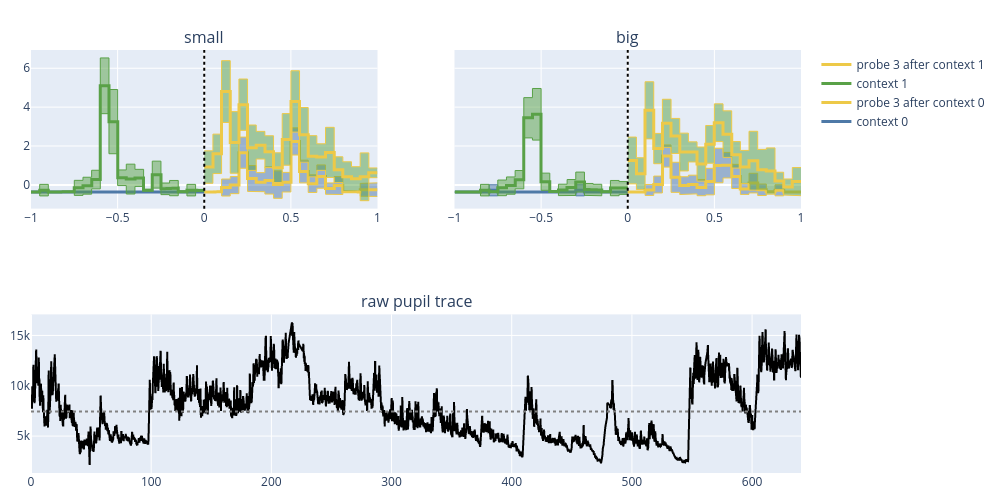

In [49]:
def plot_pupil_effect(cellid, contexts, probe):

    big = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='small')['data']
    small = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='big')['data']

    fig = make_subplots(rows=2, cols=2, shared_yaxes='rows', shared_xaxes=False,
                        subplot_titles=['small', 'big', 'raw pupil trace'],

                        specs=[[{}, {}],
                               [{'colspan':2},None]]

                        )

    # add psth traces to the suboplots
    _ = fig.add_traces(small, rows=[1]*len(small), cols=[1]*len(small))
    _ = fig.update_traces(showlegend=False)

    _ = fig.add_traces(big, rows=[1]*len(big), cols=[2]*len(big))

    # vertical lines of probe onset
    for cc in range(2):
        _ = fig.add_vline(x=0, line=dict(color='black',
                                     dash='dot'),
                      row=1, col=cc+1)

    # raw pupil trace
    recs, _ = load(cellid.split('-')[0], rasterfs=20, recache=False, pupil=True)
    pupil_trace = recs['perm0']['pupil']._data.squeeze(axis=0)
    t = np.linspace(0,pupil_trace.size/20, pupil_trace.size, endpoint=False)

    _ = fig.add_trace(go.Scatter(x=t, y=pupil_trace, mode='lines',
                                 line=dict(color='black'),
                                 showlegend=False),
                  row=2, col=1)

    _ = fig.add_hline(y=np.median(pupil_trace),
                      line=dict(color='gray',
                                dash='dot'),
                      row=2, col=1)

    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10),)

    return fig

fig = plot_pupil_effect(cellid, ctx_pair, probe)

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

# quality controll of pupil traces

chekc all sites pupil trace, and classify by coefficient of variation

In [70]:
# acumulate all pupil traceses, caches for speed
no_pupil= {'ley070a', 'CRD003b', 'ley075b', 'ley072b', 'CRD002a'}
all_pupil_file = pl.Path(config['paths']['analysis_cache']) / f'220802_pupil_traces'

recahce_pup = False
if all_pupil_file.exists() and not recahce_pup:
    pupil_traces = jl.load(all_pupil_file)
    sites_to_add = sites.difference(set(pupil_traces.keys())).difference(no_pupil)

else:
    pupil_traces = dict()
    sites_to_add = sites.difference(no_pupil)


bads = list()
for site in tqdm(sites_to_add):
    # raw pupil trace
    try:
        recs, _ = load(site, rasterfs=20, recache=False, pupil=True)
    except:
        print(f'no pupil trace for {site}')
        bads.append(site)
        continue
    pup_trace = recs['perm0']['pupil']._data.squeeze(axis=0)
    pupil_traces[site] = pup_trace

print(f'cannot find pupil on sites:\n{bads}')
if len(sites_to_add) > 0:
    jl.dump(pupil_traces, all_pupil_file)

# coefficient of variation
print('calculating coefficient of variation...')
var_coef = {key:np.std(pup_trace) / np.mean(pup_trace) for key, pup_trace in pupil_traces.items()}
print('done')

0it [00:00, ?it/s]

cannot find pupil on sites:
[]
calculating coefficient of variation...
done


In [79]:
pup_df = pd.Series(var_coef, name='CV').rename_axis('site').reset_index()
pup_df = pup_df.sort_values(by='CV', ascending=False)
pup_df

site        CV
2   CRD012b  0.931146
16  AMT032a  0.799976
37  TNC051a  0.602092
46  ARM019a  0.453658
29  TNC044a  0.435534
19  TNC048a  0.427811
53  AMT029a  0.416662
23  ARM023a  0.403069
50  ARM021b  0.400226
40  ARM024a  0.370095
32  TNC029a  0.369574
30  CRD018d  0.368401
44  AMT028b  0.368290
42  TNC006a  0.363441
54  AMT026a  0.347430
25  ARM028b  0.345126
52  AMT020a  0.340626
51  ARM025a  0.332295
15  ARM022b  0.323043
22  AMT030a  0.321905
11  TNC047a  0.318160
35  ARM026b  0.313242
28  TNC050a  0.285214
0   ARM017a  0.283674
38  ARM033a  0.276386
57  TNC028a  0.273833
13  ARM027a  0.265971
14  ARM032a  0.264462
33  TNC017a  0.262816
47  TNC016a  0.260617
45  TNC014a  0.257660
8   TNC024a  0.246355
49  TNC022a  0.242756
21  TNC043a  0.238485
31  ARM018a  0.222308
5   TNC021a  0.219384
34  ARM029a  0.191728
48  ARM031a  0.191691
39  CRD011c  0.190629
56  CRD014b  0.182908
24  TNC023a  0.180856
4   TNC013a  0.177695
10  TNC019a  0.177668
17  TNC045a  0.173881
26  CRD004a  0.173771
18  TNC018a  0.171244
12  TNC010a  0.165672
9   TNC009a  0.165174
3   TNC012a  0.158614
7   ARM005e  0.157193
6   TNC049a  0.155630
43  TNC008a  0.152783
36  AMT021b  0.150972
27  TNC015a  0.147972
55  CRD005b  0.147419
58  TNC020a  0.146430
20  TNC062a  0.141301
41  CRD019b  0.133547
1   TNC011a  0.113156

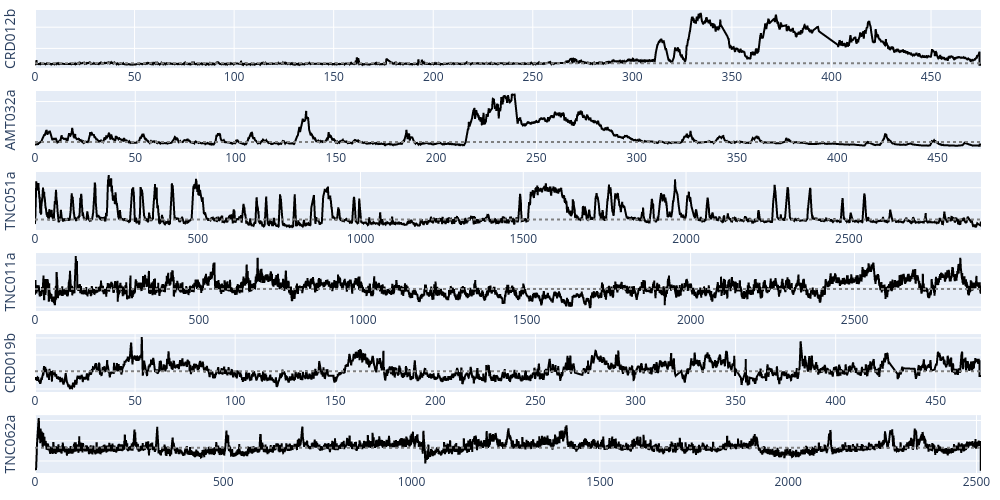

In [88]:
# plot 3 examples of the best and the worst pupil traces based on coefficient of variation

sel_sites =  pup_df.head(3)['site'].tolist() + pup_df.tail(3)['site'].tolist()[::-1]
fig = make_subplots(6,1)

for rr, site in enumerate(sel_sites):
    pupil_trace =  pupil_traces[site]
    t = np.linspace(0,pupil_trace.size/20, pupil_trace.size, endpoint=False)

    _ = fig.add_trace(go.Scatter(x=t, y=pupil_trace, mode='lines',
                                 line=dict(color='black'),
                                 showlegend=False),
                  row=rr+1, col=1)

    _ = fig.add_hline(y=np.median(pupil_trace),
                      line=dict(color='gray',
                                dash='dot'),
                      row=rr+1, col=1)

    fig.update_yaxes(ticks='', showticklabels=False, title_text=site,
                     row=rr+1, col=1)

fig.update_layout(margin=dict(l=10,r=10,t=10,b=10))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)


# Summary across all sites
select and compare only significant instances

In [2]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',
           # 'mass_center', 'last_bin',
           ]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")
DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

# Second pass

Using the absolute delta FR, while more similar to the T-score integral, is sketchy.
furthermor the results show an increase in contextula effects for small pupil, but there is no way of knowing what
is the specific mechanism of this. Is pupil increasesing or decrasing the overall firing rate
and how does this effect on context indepnendent, pairwise comparison independent, affects the
delta firing rate?

In [3]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
DF_fr_pup = jl.load(fr_DF_file)

# Calculate delta firing rate for pairs of contexts
DF_dfr = DF_fr_pup.query("part == 'probe'"
                     ).pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                   values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
             (2 * factorial(DF_dfr.shape[1] - 2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx, (c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = DF_dfr.values[:, c0] - DF_dfr.values[:, c1]

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())
print(DF_dfr.shape)

             id     site chunk  probe  pupil context_pair  delta_fr
0  AMT020a-02-1  AMT020a     A      1    big        00_01  0.377355
1  AMT020a-02-1  AMT020a     A      1   full        00_01  0.023500
2  AMT020a-02-1  AMT020a     A      1  small        00_01 -0.137083
3  AMT020a-02-1  AMT020a     A      2    big        00_01  0.417777
4  AMT020a-02-1  AMT020a     A      2   full        00_01  0.141000
(7454700, 7)


In [ ]:
# figure out a flipper filte to make all the pupil independent FR possitive

## compare FR by pupil

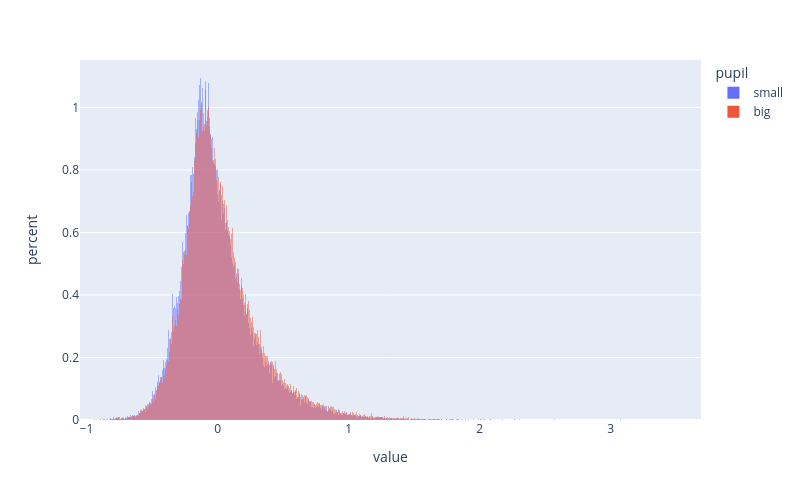

In [17]:
toplot = DF_fr_pup.query("part == 'probe' and pupil != 'full' and chunk == 'full'")
fig = px.histogram(data_frame=toplot, x='value', color='pupil', barmode='overlay',
                   histnorm='percent')

img_bytes = fig.to_image(format="png", width=800, height=500)
Image(img_bytes)

In [19]:
pivoted = toplot.pivot_table(values='value', index=['id', 'context', 'probe'], columns='pupil').reset_index()
pivoted

pupil             id  context  probe       big     small
0       AMT020a-02-1        0      1  0.356334 -0.260540
1       AMT020a-02-1        0      2  0.713729  0.058578
2       AMT020a-02-1        0      3  0.444459  0.331855
3       AMT020a-02-1        0      4  0.506146 -0.063728
4       AMT020a-02-1        1      1  0.206069  0.064682
...              ...      ...    ...       ...       ...
108265  TNC062a-40-1        9      5 -0.364112 -0.292776
108266  TNC062a-40-1        9      6  0.447879  0.470297
108267  TNC062a-40-1        9      7 -0.472436 -0.429503
108268  TNC062a-40-1        9      8 -0.294605 -0.300702
108269  TNC062a-40-1        9      9 -0.007435  0.087679

[108270 rows x 5 columns]

comparing 108270 values
LinregressResult(slope=0.7282186175826618, intercept=-0.02077981842054598, rvalue=0.7623855772213993, pvalue=0.0, stderr=0.0018785549924223695, intercept_stderr=0.0005806041047954778)


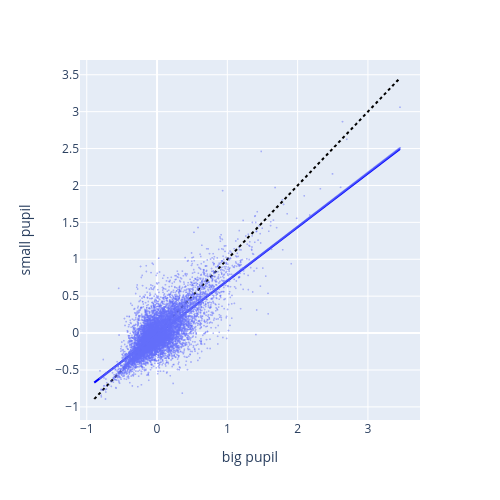

In [27]:
x = pivoted['big'].values
y = pivoted['small'].values

regression = sst.linregress(x,y)
print(f'comparing {x.size} values\n{regression}')


# xm, ym = get_quantile_means(x, y, 1000)

decimator = np.random.choice(x.size, int(x.size/10), replace=False)
xm, ym = x[decimator], y[decimator]

fig = px.scatter(x=xm, y=ym, trendline='ols')
fig.update_traces(marker=dict(opacity=0.7, size=2), opacity=0.7)

interval = np.asarray([np.min(np.concatenate([xm, ym])),
                       np.max(np.concatenate([xm, ym]))])

# linear regression, on all data, independent of decimantioon
fig.add_trace(go.Scatter(x= interval,
                         y= regression.intercept + regression.slope * interval,
                         mode='lines',
                         line=dict(dash='solid',
                                   color='blue'),
                         showlegend=False
                         )
              )

# identity line
fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                         line=dict(dash='dot',
                                   color='black'),
                         showlegend=False
                         )
              )
fig.update_xaxes(title_text='big pupil')
fig.update_yaxes(title_text='small pupil')

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

In [152]:
# creates filter for contextual effects quantiles
# todo take the mean per probe to broadcast to DF with no context pair information
signif_filter = DF.query("chunk == 'full'").copy()

signif_filter[['c0', 'c1']] = signif_filter['context_pair'].str.split('_',expand=True).astype(int)

signif_filter = pd.melt(signif_filter, id_vars=['id', 'probe', 'value'], value_vars=['c0', 'c1'],  var_name='src_ctx', value_name='context')

signif_filter = signif_filter.groupby(['id','context','probe']).agg(value=('value','mean')).reset_index()

signif_filter['quality'] = pd.qcut(signif_filter['value'].astype(float), q=4,
                               labels=['worst', 'bad','good', 'best'], retbins=False)
signif_filter.head(10)

id  context  probe       value quality
0  AMT020a-08-1        1      3  312.353775   worst
1  AMT020a-08-1        1      4  531.349201     bad
2  AMT020a-08-1        2      3  341.067869   worst
3  AMT020a-08-1        2      4  531.349201     bad
4  AMT020a-08-1        3      3  360.554823   worst
5  AMT020a-08-1        4      3  365.168393   worst
6  AMT020a-16-1        0      2  692.754595    good
7  AMT020a-16-1        2      2  692.754595    good
8  AMT020a-16-2        0      1  451.739539     bad
9  AMT020a-16-2        0      3  377.491722   worst

In [159]:
toplot = DF_fr_pup.query("part == 'probe' and pupil != 'full' and chunk == 'full'")
toplot = pd.merge(toplot, signif_filter.loc[:,['id', 'context', 'probe', 'quality']], on=['id', 'context', 'probe'])

toplot = toplot.pivot_table(values='value', index=['id', 'context', 'probe', 'quality'], columns='pupil').reset_index()
toplot['pupil_diff'] = toplot['big'] - toplot['small']
fig = px.histogram(toplot, x='pupil_diff',facet_col='quality',
                   category_orders={'quality':['worst','bad','good','best']})
fig.show()

## compare context effects by pupil

In [4]:
filter_df = DF.query("chunk != 'full'").copy()
filter_df['quality'] = pd.qcut(filter_df['value'].astype(float), q=4, labels=['worst', 'bad', 'good', 'best'])
filter_df.head(5)

id context_pair probe       value      metric     site region  \
850  AMT029a-35-1        00_01     1  540.689765  integral_A  AMT029a    PEG   
852  AMT029a-43-1        00_01     1  115.040754  integral_A  AMT029a    PEG   
853  AMT029a-48-1        00_01     1  432.214358  integral_A  AMT029a    PEG   
856  AMT029a-51-1        00_01     1  358.975816  integral_A  AMT029a    PEG   
859  AMT029a-57-1        00_01     1  336.460609  integral_A  AMT029a    PEG   

     stim_count chunk quality  
850           4     A    good  
852           4     A   worst  
853           4     A     bad  
856           4     A     bad  
859           4     A   worst

In [5]:
# filters data for significant instanceses
merged = pd.merge(DF_dfr, filter_df.loc[:,['id', 'context_pair', 'probe', 'chunk', 'quality']],
                  on=['id', 'context_pair', 'probe', 'chunk'],
                  validate='m:1')


In [6]:
merged

id     site chunk probe  pupil context_pair  delta_fr  \
0       AMT020a-16-2  AMT020a     A     3    big        00_01  0.398733   
1       AMT020a-16-2  AMT020a     A     3   full        00_01  0.312052   
2       AMT020a-16-2  AMT020a     A     3  small        00_01  0.252163   
3       AMT020a-16-2  AMT020a     A     4    big        00_01  0.499283   
4       AMT020a-16-2  AMT020a     A     4   full        00_01  0.520086   
...              ...      ...   ...   ...    ...          ...       ...   
181141  TNC051a-43-1  TNC051a     A     8   full        09_10 -0.466673   
181142  TNC051a-43-1  TNC051a     A     8  small        09_10 -0.294448   
181143  TNC051a-43-1  TNC051a     A    10    big        09_10  0.507943   
181144  TNC051a-43-1  TNC051a     A    10   full        09_10  0.533341   
181145  TNC051a-43-1  TNC051a     A    10  small        09_10  0.566674   

       quality  
0          bad  
1          bad  
2          bad  
3          bad  
4          bad  
...        ...  
181141     bad  
181142     bad  
181143     bad  
181144     bad  
181145     bad  

[181146 rows x 8 columns]

In [ ]:
mtrc = 'delta_fr'

pivoted = merged.pivot_table(index=['id', 'context_pair', 'probe', 'chunk', 'quality'], columns='pupil', values=mtrc,
                             aggfunc='first').reset_index()
pivoted.head(10)

In [ ]:


pivoted['pupil_diff'] = pivoted['big'] - pivoted['small']

style = 'hist'

if style == 'scatter':
    fig = px.scatter(pivoted, x='small', y='big',
                     facet_col='chunk', facet_row='quality',
                     category_orders={'chunk':['A', 'B', 'C', 'D', 'full'],
                                      'quality': ['worst', 'bad', 'good', 'best']},
                     color='chunk', trendline='ols')

    fig.update_traces(marker=dict(opacity=0.5,
                                  size=1),
                      opacity=0.5)

    interval = [merged[mtrc].min(), merged[mtrc].max()]

    for col in range(len(pivoted.chunk.unique())):
        for row in range(len(pivoted.quality.unique())):
            fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                                     line=dict(color='black',
                                               dash='dot',),
                                     showlegend=False),
                          row=1, col=col+1
                          )

    fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain')

elif style == 'hist':
    fig = px.ecdf(pivoted, x='pupil_diff',
                       facet_col='chunk', color='quality',
                       category_orders={'chunk':['A', 'B', 'C', 'D', 'full'],
                                      'quality': ['worst', 'bad', 'good', 'best']},
                       ecdfnorm='percent')


# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

In [12]:
pivoted

pupil            id context_pair  probe chunk quality       big     small  \
0      AMT020a-08-1        01_02      3     A   worst  1.492646  0.118009   
1      AMT020a-08-1        01_02      4     A    good  1.569794  0.664144   
2      AMT020a-08-1        02_04      3     A     bad -0.452825 -0.505655   
3      AMT020a-08-1        03_04      3     A     bad -0.439103 -0.582803   
4      AMT020a-16-1        00_02      2     A    good  1.225441  0.541422   
...             ...          ...    ...   ...     ...       ...       ...   
60377  TNC062a-40-1        05_09      8     B   worst  0.360403  0.547625   
60378  TNC062a-40-1        06_07      6     A     bad -0.533695 -0.324972   
60379  TNC062a-40-1        06_09      8     B     bad  0.421250  0.634093   
60380  TNC062a-40-1        07_08      6     A   worst  0.545224  0.321450   
60381  TNC062a-40-1        07_09      8     B    good  0.642222  0.605270   

pupil  pupil_diff  
0        1.374637  
1        0.905651  
2        0.052830  
3        0.143700  
4        0.684019  
...           ...  
60377   -0.187222  
60378   -0.208722  
60379   -0.212842  
60380    0.223774  
60381    0.036952  

[60382 rows x 8 columns]

In [16]:
out = pivoted.groupby(['chunk', 'quality']).apply(lambda x: sst.wilcoxon(x.big,x.small))
out = pd.DataFrame(out.tolist(), index=out.index)
out['significant'] = out['pvalue'] < (0.05/out.shape[0])
out

statistic        pvalue  significant
chunk quality                                       
A     worst    12648119.5  6.429215e-06         True
      bad      33506604.5  7.415716e-01        False
      good     30293663.5  1.687440e-03         True
      best     28946956.5  7.195088e-09         True
B     worst     7255320.5  6.830232e-01        False
      bad       1263706.0  2.319453e-01        False
      good      1573031.5  9.699740e-01        False
      best      1439760.5  8.350410e-09         True
C     worst      623606.0  7.902921e-01        False
      bad        148330.5  4.525985e-01        False
      good       209817.0  7.309967e-03        False
      best       249862.5  1.254392e-01        False
D     worst      110519.0  1.255499e-01        False
      bad         32619.5  5.568093e-02        False
      good        33779.0  8.654854e-04         True
      best        34591.5  1.396233e-02        False